# <a href="https://thetahat.ru/courses/ph-ds-2024-aut">Phystech@DataScience</a>
## Семинар 10 (Часть 2)

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


In [ ]:
# Bot check

# HW_ID: phds_sem10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

## Реализации непараметрических критериев в Python

### Критерий Смирнова <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \not= G$

Альтернатива двусторонняя, б*о*льшие значения статистики являются более экстремальными.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp">`ks_2samp`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки

---

Определим несколько вспомогательных функций для отрисовки графиков

In [2]:
def ecdf(sample):
    """
    Вычисляет точки по X и по Y для построения ЭФР по выборке sample.
    Учитываются как горизонтальные, так и вертикальные линии.
    """

    # дублируем выборку и добавляем значения слева и справа
    x = deepcopy(list(sample)*2 + [sample.min()-0.5, sample.max()+0.5])
    # каждое значение два раза
    y = deepcopy(list(np.linspace(0, 1, len(sample)+1)) * 2)

    return np.sort(x), np.sort(y)


def max_diff(x1, x2, y1, y2):
    """ Вычисляет, где достигается максимальная разница между двумя ЭФР. """

    # объединим наборы и отсортируем по иксу
    x_all, y_all = np.hstack([x1, x2]), np.hstack([y1, y2])
    order = np.argsort(x_all)
    x_all, y_all = x_all[order], y_all[order]

    # найдем индекс наибольшейарзницы по Y между соседними
    i = np.argmax(np.abs(y_all[1:] - y_all[:-1]))

    # точка наибольшей разности и значения  в ней
    return (x_all[i+1] + x_all[i]) / 2, y_all[i], y_all[i+1]

In [3]:
def apply_smirnov(distr1, distr2, size1=100, size2=100):
    """
    Генерирует выборки из заданных распределений,
    строит графики теоретических и эмпирических функций распределения,
    применяет критерий Смирнова.

    distr1, distr2 -- распределения для генерации выборок
    size1, size2 -- размеры выборок
    """

    # генерируем выборки
    sample_1 = distr1.rvs(size=size1)
    sample_2 = distr2.rvs(size=size2)

    # определяем границы графика
    x_min = min(distr1.ppf(0.01), distr2.ppf(0.01))
    x_max = max(distr1.ppf(0.99), distr2.ppf(0.99))
    grid = np.linspace(x_min, x_max, 200)

    plt.figure(figsize=(16, 5))

    # График истинных функций распределения
    plt.subplot(121)
    plt.plot(grid, distr1.cdf(grid), lw=3)
    plt.plot(grid, distr2.cdf(grid), lw=3)
    plt.title('CDF')

    # График эмпирических функций распределения
    plt.subplot(122)
    x1, y1 = ecdf(sample_1)
    plt.plot(x1, y1, lw=3)
    x2, y2 = ecdf(sample_2)
    plt.plot(x2, y2, lw=3)
    plt.vlines(*max_diff(x1, x2, y1, y2), color='gray')
    plt.title('ECDF')

    # Применяем критерий Смирнова
    print(sps.ks_2samp(sample_1, sample_2))

Сравним нормальные с разными средними

KstestResult(statistic=0.49, pvalue=2.948425133635738e-11, statistic_location=0.1030784959304991, statistic_sign=1)


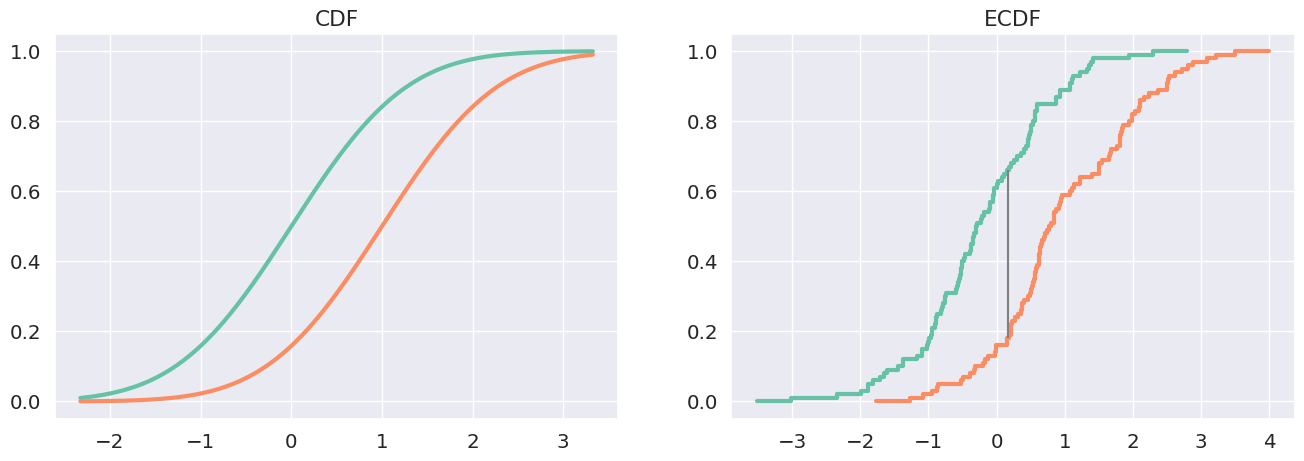

In [4]:
apply_smirnov(sps.norm(loc=0), sps.norm(loc=1))

Сравним нормальные с разными дисперсиями и разными размерами выборок

KstestResult(statistic=0.256, pvalue=0.040285604326327176, statistic_location=-1.4553236380079153, statistic_sign=-1)


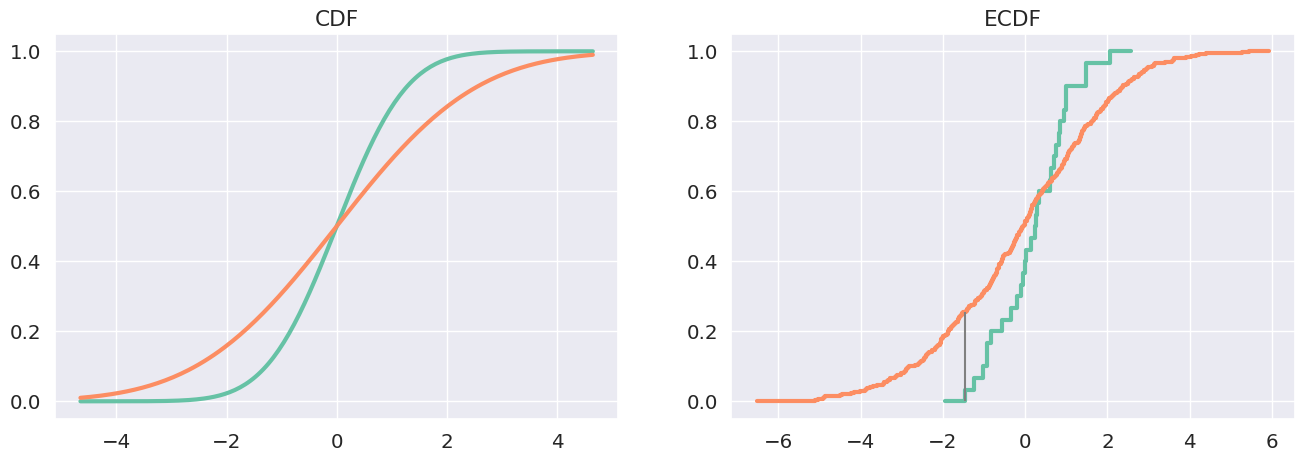

In [5]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=30, size2=500)

Если увеличить размер выборки

KstestResult(statistic=0.154, pvalue=1.3671719473054452e-05, statistic_location=-1.3920466485543002, statistic_sign=-1)


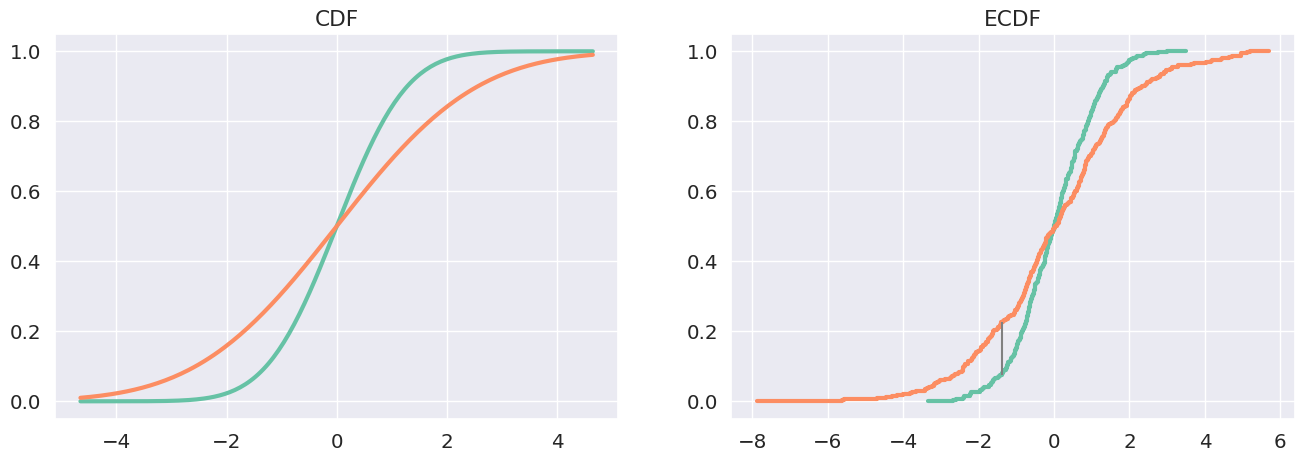

In [6]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=500, size2=500)

Маленькое отклонение при очень больших выборках

KstestResult(statistic=0.013520000000000088, pvalue=0.00021268961194239553, statistic_location=0.7693647414812227, statistic_sign=1)


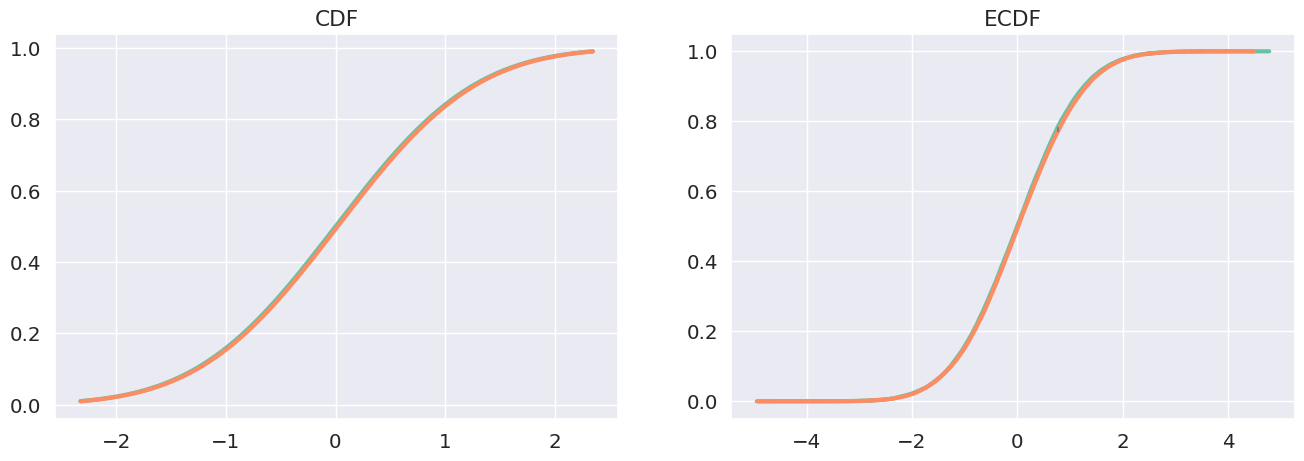

In [7]:
apply_smirnov(sps.norm, sps.norm(loc=0.02),
              size1=50000, size2=50000)

Сравним нормальное и Коши

KstestResult(statistic=0.2, pvalue=0.03638428787491733, statistic_location=-1.3078718158510558, statistic_sign=-1)


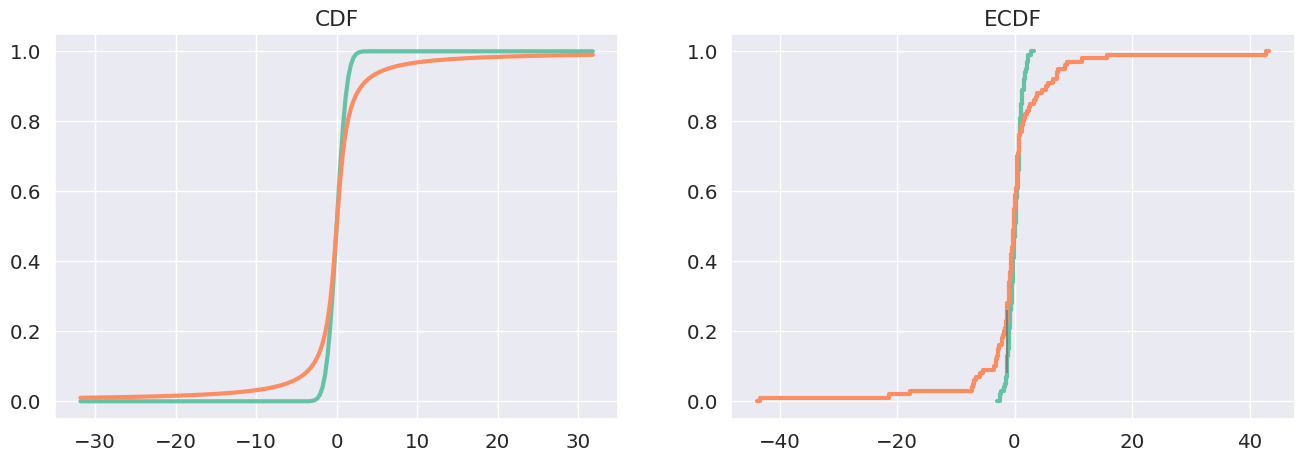

In [8]:
apply_smirnov(sps.norm, sps.cauchy)

Сравним нормальное и Лапласса

KstestResult(statistic=0.18, pvalue=0.07822115797841851, statistic_location=0.34035028946988954, statistic_sign=1)


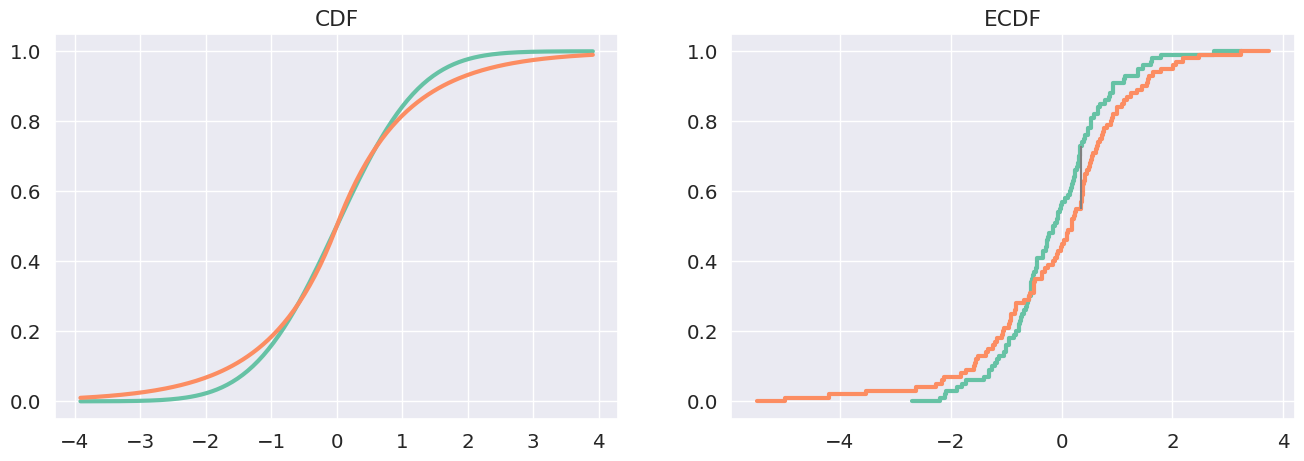

In [9]:
apply_smirnov(sps.norm, sps.laplace)

### Критерий ранговых сумм Уилкоксона-Манна-Уитни <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

------

* **"Критерий Уилкоксона"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем это не значит, что $\mathsf{H}_1\colon F \not= G$.

Используется нормированная версия статистики $V = S_1 + ... + S_m$ &mdash; сумма рангов наблюдений $Y_j$ по объединенной выборке.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html#scipy.stats.ranksums">`ranksums`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки.

------

* **"Критерий Манна-Уитни"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \leqslant G$ или $\mathsf{H}_1\colon F \geqslant G$ или $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$

Используется статистика $U = \sum\limits_{i=1}^n \sum\limits_{j=1}^m I\{X_i < Y_j\}$, причем $U = V - \frac{m(m+1)}{2}$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu">`mannwhitneyu`</a>`(data1, data2, use_continuity=True, alternative=None): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки;

* `use_continuity` &mdash; использовать ли поправку 0.5 на непрерывность;
* `alternative='less'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \leqslant G$;
* `alternative='greater'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \geqslant G$;
* `alternative='two-sided'` &mdash; используется альтернатива $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем эквивалентен `ranksums`.

---

Примеры

In [10]:
def print_tests(sample_1, sample_2):
    print(sps.ranksums(sample_1, sample_2))
    print('two-sided:', sps.mannwhitneyu(sample_1, sample_2, alternative='two-sided'))
    print('less:     ', sps.mannwhitneyu(sample_1, sample_2, alternative='less'))
    print('greater:  ', sps.mannwhitneyu(sample_1, sample_2, alternative='greater'))

In [11]:
print_tests(sps.norm.rvs(size=100), sps.norm.rvs(size=100))

RanksumsResult(statistic=1.4244957211945188, pvalue=0.15430302281627753)
two-sided: MannwhitneyuResult(statistic=5583.0, pvalue=0.15465673328954493)
less:      MannwhitneyuResult(statistic=5583.0, pvalue=0.9230250363152888)
greater:   MannwhitneyuResult(statistic=5583.0, pvalue=0.07732836664477247)


In [12]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1).rvs(size=100))

RanksumsResult(statistic=-5.983859384571829, pvalue=2.17911457631739e-09)
two-sided: MannwhitneyuResult(statistic=2551.0, pvalue=2.195527743700183e-09)
less:      MannwhitneyuResult(statistic=2551.0, pvalue=1.0977638718500914e-09)
greater:   MannwhitneyuResult(statistic=2551.0, pvalue=0.9999999989185895)


In [13]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1, scale=10).rvs(size=100))

RanksumsResult(statistic=-0.06108472217815261, pvalue=0.9512917363637895)
two-sided: MannwhitneyuResult(statistic=4975.0, pvalue=0.952264726653991)
less:      MannwhitneyuResult(statistic=4975.0, pvalue=0.4761323633269955)
greater:   MannwhitneyuResult(statistic=4975.0, pvalue=0.5248405906589573)


In [14]:
print_tests(sps.cauchy.rvs(size=100), sps.cauchy(loc=1).rvs(size=100))

RanksumsResult(statistic=-2.761029442452498, pvalue=0.005761948174876581)
two-sided: MannwhitneyuResult(statistic=3870.0, pvalue=0.005783538551978307)
less:      MannwhitneyuResult(statistic=3870.0, pvalue=0.0028917692759891536)
greater:   MannwhitneyuResult(statistic=3870.0, pvalue=0.9971297847488411)


### Критерий ранговых сумм Уилкоксона <font color="red">(парные выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_n$ &mdash; связные выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

Предполагается, что $Z_i = Y_i - X_i = \theta + \varepsilon_i$, причем $\varepsilon_i$ независимы одинаково распределены, причем распределение непрерывное симметричное относительно нуля.

Проверяются гипотезы

$\mathsf{H}_0\colon \theta = 0$,

$\mathsf{H}_1\colon \theta \not= 0$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon">`wilcoxon`</a>`(x, y=None, zero_method='wilcox'): statistic, pvalue`

* `x`, `y` &mdash; выборки. Если `y=None`, то в `x` разности;
* `zero_method='pratt'` &mdash; нулевые разности остаются (более консервативен);
* `zero_method='wilcox'` &mdash; нулевые разности выкивываются;
* `zero_method='zsplit'` &mdash; нулевые разности распределяются между положительными и отрицательными рангами.

---

Примеры:

In [15]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=2396.0, pvalue=0.6573723697180689)

In [16]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=397.0, pvalue=2.540385380669566e-13)

In [17]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=-0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=368.0, pvalue=1.2028611792100838e-13)

Времена реакции (Лагутин)

In [18]:
sample_1 = [176, 163, 152, 155, 156, 178, 160, 164, 169, 155, 122, 144]
sample_2 = [168, 215, 172, 200, 191, 197, 183, 174, 176, 155, 115, 163]
print('wilcox:', sps.wilcoxon(sample_1, sample_2))
print('pratt: ', sps.wilcoxon(sample_1, sample_2, zero_method='pratt'))
print('zsplit:', sps.wilcoxon(sample_1, sample_2, zero_method='zsplit'))

wilcox: WilcoxonResult(statistic=4.5, pvalue=0.011197738894413023)
pratt:  WilcoxonResult(statistic=6.5, pvalue=0.011931715346446874)
zsplit: WilcoxonResult(statistic=7.0, pvalue=0.011997435448298963)


## Отток клиентов телекома

Загрузим <a href="https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv">данные</a> о клиентах оператора связи, которые содержат некоторую информацию тарифном плане клиента, статистику его использования услуг связи, а также его текущий статус `Churn` &mdash; ушел или нет.

In [20]:
telecom = pd.read_csv('./telecom_churn.csv')
telecom.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Одинаково ли распределено количество минут днем?

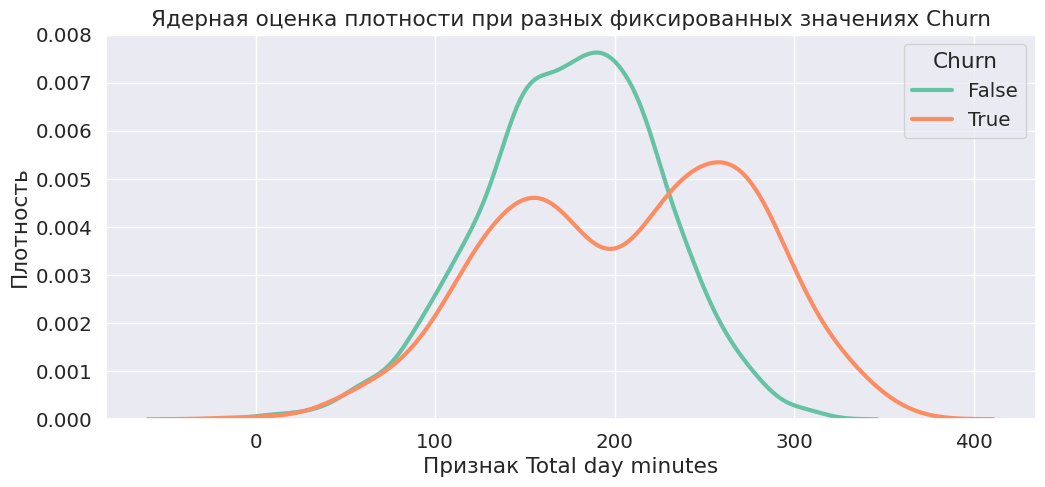

In [21]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total day minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total day minutes'],
            label='True', lw=3)
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности при разных фиксированных значениях Churn')
plt.ylabel('Плотность')
plt.xlabel('Признак Total day minutes')

plt.show()

Проверьте гипотезу однородности.

Какой критерий вы бы выбрали? Какую альтернативу стоит использовать?

**Ответ:** критерий уилкоксона-манна-уитни
потому что данные не имеют нормального распределения

In [23]:
x = telecom[telecom['Churn'] == False]['Total day minutes']
y = telecom[telecom['Churn'] == True]['Total day minutes']

u_stat, p_value = sps.mannwhitneyu(x, y)

print(f'U-статистика: {u_stat}')
print(f'p-value: {p_value}')


if p_value < 0.05:
    print('отвергаем нулевую гипотезу: есть статистически значимые различия между группами')
else:
    print('не отвергаем нулевую гипотезу: нет статистически значимых различий между группами')


U-статистика: 495604.0
p-value: 6.715053420859948e-23
отвергаем нулевую гипотезу: есть статистически значимые различия между группами


Для дальнейшего использования реализуем функцию оценки сдвига и функцию доверительного интервала оценки.

Учтите, что по сравнению с формулами для доверительного интервала, из индексов надо вычесть 1, поскольку используется нумерация с нуля.

In [25]:
def shift(x, y):
    '''Вычисление оценки параметра сдвига из критерия ранговых сумм Уилкоксона'''
    shift = np.median(x) - np.median(y)
    return shift

def confidence_interval(x, y, alpha=0.05):
    '''Вычисление границ доверительного интервала параметра сдвига из критерия ранговых сумм Уилкоксона'''
    n1 = len(x)
    n2 = len(y)
    n = n1 + n2
    U, _ = sps.mannwhitneyu(x, y)
    std_U = np.sqrt((n1 * n2 * (n + 1)) / 12)
    z = (U - (n1 * n2 / 2)) / std_U
    z_alpha = sps.norm.ppf(1 - alpha / 2)
    left = shift(x, y) - z_alpha * std_U / np.sqrt(n1 * n2)
    right = shift(x, y) + z_alpha * std_U / np.sqrt(n1 * n2)
    return left, right

Оценим сдвиг

In [26]:
shift_value = shift(x, y)
print(shift_value)

-40.400000000000006


Получите доверительный интервал величины сдвига.

In [27]:
left_bound, right_bound = confidence_interval(x, y)
print(f'Доверительный интервал: ({left_bound}, {right_bound})')

Доверительный интервал: (-73.0693328523278, -7.730667147672207)


оба метода показывают отвережение нулевой гипотезы

### Одинаково ли распределено количество минут ночью?

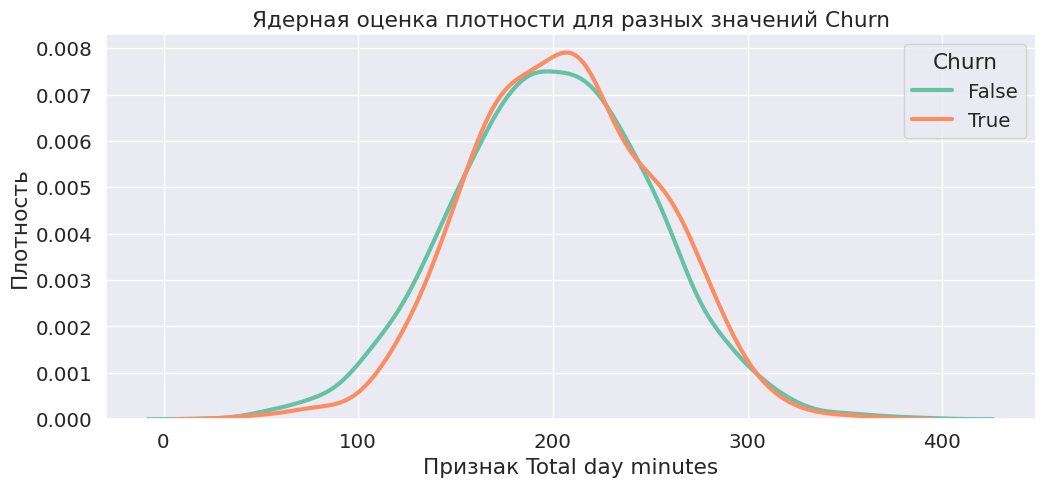

In [28]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total night minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total night minutes'],
            label='True', lw=3)
plt.xlabel('Признак Total day minutes')
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности для разных значений Churn')
plt.ylabel('Плотность')

plt.show()

Проверьте с помощью критерия.

In [29]:
x = telecom[telecom['Churn'] == False]['Total night minutes']
y = telecom[telecom['Churn'] == True]['Total night minutes']

u_stat, p_value = sps.mannwhitneyu(x, y)

print(f'U-статистика: {u_stat}')
print(f'p-value: {p_value}')


if p_value < 0.05:
    print('отвергаем нулевую гипотезу: есть статистически значимые различия между группами')
else:
    print('не отвергаем нулевую гипотезу: нет статистически значимых различий между группами')


U-статистика: 649507.0
p-value: 0.04744034531465515
отвергаем нулевую гипотезу: есть статистически значимые различия между группами


Получим оценку сдвига.

In [30]:
shift_value = shift(x, y)
print(shift_value)

-4.550000000000011


Получим доверительный интервал.

In [31]:
left_bound, right_bound = confidence_interval(x, y)
print(f'Доверительный интервал: ({left_bound}, {right_bound})')

Доверительный интервал: (-37.21933285232781, 28.119332852327787)


Что вы можете сказать о проверке критерием, об оценке сдвига и о её доверительном интервале?

**Ответ:** доверительный интервал включает ноль, значит, нет статистических различий между группами, разные способы показали разные выводы, это странно

Распределения по графику похожи на нормальные, проверьте эту гипотезу. При прохождении критерия проверьте параметрическим критерием однородность выборок. Нужно ли использовать что-то ещё при проверке?

**Вывод:**